make enrichment plots for snvs!

In [1]:
import sys
sys.path.append('/home/kal/K27act_models/convolution_model/')
sys.path.append('/home/kal/K27act_models/cg_model/')
sys.path.append('/home/kal/TF_models/bin/')

import sequence
import train_TFmodel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ucscgenome
from tqdm import tqdm
import datagen

from keras.models import load_model
import pickle


#load in the DNA
genome19 = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
genome38 = ucscgenome.Genome('/home/kal/.ucscgenome/hg38.2bit')

Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [38]:
# get some datasets!
ibd_c = pd.read_table('/home/kal/K27act_models/eqtl_data/IBD_credible_sets.csv')
ibd_all = pd.read_table('/home/kal/K27act_models/eqtl_data/IBD_list_of_varients.csv')
eqtl = pd.read_table('/home/kal/K27act_models/eqtl_data/Cells_EBV-transformed_lymphocytes.hg38.txt')

In [3]:
# get some models! 
fbaseline_models = {'3f':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_atac_regression_fold_change.pk', 'rb'))}
kbaseline_models = {'3k':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}
fml_models = {'fpwm':load_model('/home/kal/K27act_models/convolution_model/20180628_132455_fold_pwm/final_model.h5'), 
             'fconv':load_model('/home/kal/K27act_models/convolution_model/20180628_162107_conv_fold/final_model.h5')}
#kml_models = {'kpwm':load_model('/home/kal/K27act_models/convolution_model/20180628_144341_counts_pwm/intermediate_weights/weights-13-3.704.hdf5')}

In [4]:
def snv_gen(peaks, genome, alt=False, seq_length=1024):
    """Generate sequnces from snv data.
    
    Arguments:
        peaks -- from a bed file.
        genome -- to pull bed from.
    Keywords:
        alt -- give alternate allele version.
    Returns:
        seq -- sequence with the alternate or refernce allele, centered around the position. """
    for index, row in peaks.iterrows():
        try:
            seq = datagen.get_sample(row, genome=genome)[0]
            if alt:
                new_seq = np.insert(sequence.encode_to_onehot(row.altAllele.lower()), 0, seq[seq_length//2:seq_length//2+len(row.altAllele)][:,0], axis=1)
                part_seq = np.append(seq[:seq_length//2], new_seq, axis=0)
                seq = np.append(part_seq, seq[seq_length//2+len(row.refAllele):], axis=0) 
            else:
                new_seq = np.insert(sequence.encode_to_onehot(row.refAllele.lower()), 0, seq[seq_length//2:seq_length//2+len(row.refAllele)][:,0], axis=1)
                part_seq = np.append(seq[:seq_length//2], new_seq, axis=0)
                seq = np.append(part_seq, seq[seq_length//2+len(row.refAllele):], axis=0)
            if (row.refAllele).lower()[0] != (genome[row.chr][row.position]).lower():
                print('Should be {}'.format(genome[row.chr][row.position].lower()))
                print('Actually is {}'.format(row.refAllele.lower()))
                print('Alternate is {}'.format(row.altAllele.lower()))
                raise IndexError('Reference allele does not match reference genome')
            yield seq
        except IndentationError as e:
            print(e)
            print(row)
        

In [27]:
def predict_snv(model, peaks, genome=None, act=False):
    """Predict from a bed file with chr, position, refAllele, altAllele.
 
    Arguments:
        peaks -- the bed file in pd table form.
    Keywords:
        genome -- default is hg19.
    Outputs:
        refpreds -- predictions for each row with reference allele. 
        altpreds -- predictions for each row with alternate allele. 
    """
     # get the genome and bed file regions
    if genome == None:
        genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
    # predict over the rows
    refpreds = []
    peaks['end'] = peaks['refend']
    batchgen = train_TFmodel.filled_batch(snv_gen(peaks, genome, alt=False), fillvalue=np.zeros((1024, 5)))
    for batch in batchgen:
        if batch.shape == (32, 1024, 5):
            refpreds.append(model.predict_on_batch(batch))
    refpreds = np.asarray(refpreds).flatten()[:len(peaks)]

    altpreds = []
    peaks['end'] = peaks['altend']
    batchgen = train_TFmodel.filled_batch(snv_gen(peaks, genome, alt=True), fillvalue=np.zeros((1024, 5)))
    for batch in batchgen:
        if batch.shape == (32, 1024, 5):
            altpreds.append(model.predict_on_batch(batch))
    altpreds = np.asarray(altpreds).flatten()[:len(peaks)]
    return refpreds, altpreds


In [28]:
# prepare for testing
for index, row in ibd_c.iterrows():
    if len(row.refAllele) == len(row.altAllele):
        ibd_c.at[index, 'altend'] = row.position+512
    else:
        ibd_c.at[index, 'altend'] = row.position+512 + len(row.refAllele) - len(row.altAllele)
ibd_c['start'] = ibd_c.position-512
ibd_c['refend'] = ibd_c.position+512
ibd_c['score'] = np.nan
ibd_c['altend'] = ibd_c['altend'].astype(int)

ibd_c = ibd_c[(ibd_c['refAllele'] !='D') & (ibd_c['refAllele'] !='I')]# I can't deal with deletions or insertions

In [16]:
r, a = predict_snv(fml_models['fpwm'], ibd_c, genome19)

(32, 1024, 5)
(32, 1024, 5)
(32, 1024, 5)
(32, 1024, 5)
(32, 1024, 5)


In [17]:
ibd_c.keys()

Index(['HD', 'chr', 'signal', 'tier2', ' region_start ', ' region_end ',
       ' region_len ', ' credible_start ', ' credible_end ', ' credible_len ',
       'region_nSNP_total', 'region_nSNP_imp', 'region_nSNP_gen',
       'credible_nSNP', 'credible_nSNP_extra1KG_highLD',
       'credible_nSNP_extraUK10K_highLD', 'region_nGene', 'credible_nGene',
       'p_multi', 'p_single', 'trait', 'trait.reassigned', 'Prob.lead',
       'sharingBF', 'OR_CD', 'OR_UC', 'AF_1KG', 'AF_HC', 'AF_CD', 'AF_UC',
       'INFO.best', 'variant.lead', 'position', 'refAllele', 'altAllele',
       'all.variant', 'altend', 'start', 'refend', 'score', 'end'],
      dtype='object')

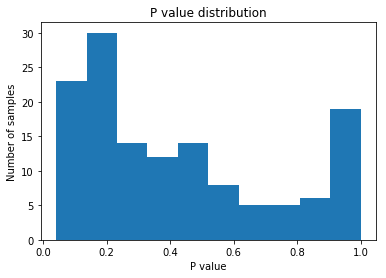

In [18]:
plt.hist(ibd_c['Prob.lead'])
plt.title('P value distribution')
plt.xlabel('P value')
plt.ylabel('Number of samples')
plt.show()

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


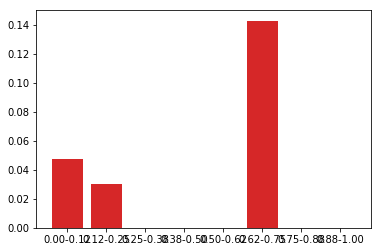

In [31]:
num_groups = 8
enrichment=[0]*num_groups
name=list()
bins=np.linspace(0, 1, num_groups+1)
for i in range(num_groups):
    ibd_subset = ibd_c[(ibd_c['Prob.lead'] >= bins[i]) & (ibd_c['Prob.lead'] < bins[i+1])]
    r, a = predict_snv(fml_models['fpwm'], ibd_subset, genome19)
    diff = r-a
    enrichment[i] = len([d for d in diff if abs(d) > 0])/len(diff)
    name.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))

plt.bar(range(num_groups), enrichment)
plt.xticks(range(num_groups), name)
plt.show()

In [39]:
# prepare for testing
for index, row in tqdm(eqtl.iterrows(), total=len(eqtl)):
    if len(row.refAllele) == len(row.altAllele):
        eqtl.at[index, 'altend'] = row.position+512
    else:
        eqtl.at[index, 'altend'] = row.position+512 + len(row.refAllele) - len(row.altAllele)
eqtl['start'] = eqtl.position-512
eqtl['refend'] = eqtl.position+512
eqtl['score'] = np.nan
eqtl['altend'] = eqtl['altend'].astype(int)

eqtl = eqtl[(eqtl['refAllele'] !='D') & (eqtl['refAllele'] !='I')]# I can't deal with deletions or insertions

print(eqtl.keys())
eqtl.head()

100%|██████████| 239048/239048 [00:19<00:00, 12333.46it/s]


Index(['chr', 'chr.1', 'position', 'position.1', 'variant_id', 'refAllele',
       'altAllele', 'gene_id', 'variant', 'prob.in.set', 'PosteriorProb',
       'gene_name', 'CredibleSetSize', 'CredibleSet', 'CredibleSetName',
       'median.expression', 'missingness', 'mappability.k50', 'tss_distance',
       'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se',
       'eqtl_name', 'altend', 'start', 'refend', 'score'],
      dtype='object')


,chr,chr.1,position,position.1,variant_id,refAllele,altAllele,gene_id,variant,prob.in.set,...,ma_count,maf,pval_nominal,slope,slope_se,eqtl_name,altend,start,refend,score
0,chr10,chr10,100327280,100327280,chr10_100327281_T_C_b38,T,C,ENSG00000224934.2,102087038,0.019453,...,36,0.122449,0.000652,0.375461,0.107300,chr10:102087038:RP11-441O15.3,100327792,100326768,100327792,NaN
1,chr10,chr10,100327355,100327355,chr10_100327356_G_T_b38,G,T,ENSG00000224934.2,102087113,0.005739,...,58,0.197279,0.001981,-0.268628,0.084970,chr10:102087113:RP11-441O15.3,100327867,100326843,100327867,NaN
2,chr10,chr10,100343279,100343279,chr10_100343280_C_T_b38,C,T,ENSG00000119929.12,102103037,0.051836,...,33,0.112245,0.000046,0.452428,0.107065,chr10:102103037:CUTC,100343791,100342767,100343791,NaN
3,chr10,chr10,100345872,100345872,chr10_100345873_T_C_b38,T,C,ENSG00000119929.12,102105630,0.441053,...,32,0.108844,0.000003,0.502150,0.102816,chr10:102105630:CUTC,100346384,100345360,100346384,NaN
4,chr10,chr10,100367734,100367734,chr10_100367735_A_G_b38,A,G,ENSG00000119929.12,102127492,0.043166,...,40,0.136054,0.000060,-0.380238,0.091461,chr10:102127492:CUTC,100368246,100367222,100368246,NaN


In [37]:
test = eqtl.sample(100)
split_column = 'PosteriorProb'

num_groups = 8
enrichment=[0]*num_groups
name=list()
bins=np.linspace(0, 1, num_groups+1)
for i in tqdm(range(num_groups)):
    test_subset = test[(test[split_column] >= bins[i]) & (test[split_column] < bins[i+1])]
    r, a = predict_snv(fml_models['fpwm'], test_subset, genome38)
    diff = r-a
    enrichment[i] = len([d for d in diff if abs(d) > 0])/len(diff)
    name.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))

plt.bar(range(num_groups), enrichment)
plt.xticks(range(num_groups), name)
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

Should be t
Actually is a
Alternate is g


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



IndexError: Reference allele does not match reference genome